In [2]:
import dask.array as da
from dask.distributed import LocalCluster, Client
import dask
import numpy as np
import os
from numpy.lib.stride_tricks import as_strided
import xarray as xr
import pandas as pd
import webbrowser


In [ ]:
def crosscorrelation(x, y, maxlag, normalize=True):
    """
    Cross correlation with a maximum number of lags, with optional normalization.

    Parameters: 
    x, y: one-dimensional numpy arrays with the same length.
    maxlag: maximum lag for which the cross correlation is computed.
    normalize: if True, calculate the normalized cross-correlation.
    
    Returns:
    An array of cross-correlation values with length 2*maxlag + 1.
    
    Credits: 
    https://stackoverflow.com/questions/30677241/how-to-limit-cross-correlation-window-width-in-numpy
    
    """
    
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')

    
    cross_corr = T.dot(px)

    cmax = float(cross_corr.max())
    the_lagmax = cross_corr.argmax() - (maxlag + 1)
    
    if normalize:
        mx = np.mean(x)
        my = np.mean(y)
        norm = float(len(y) * mx * my)

        numerator = cmax - norm

        sigma_x = np.sqrt(np.sum((x - mx) ** 2))
        sigma_y = np.sqrt(np.sum((y - my) ** 2))
        denominator = float(sigma_x * sigma_y)
        
        cmax = numerator / denominator

    return cmax, the_lagmax

In [ ]:
def analyze_chunk(data_chunk_subset, nodes, max_lag, year, outpath):
    print(data_chunk_subset)
    print(nodes)
    print(max_lag)
    
    arrays = []
    
    for i in range(data_chunk_subset.dims['num']):

        num_chunks = data_chunk_subset['t2m'].isel(num=i)
        numpy_array = np.zeros((37*72, 37*72))  
        
        for indi, nod in enumerate(nodes):
            Ai, Aj = nodes[indi]
            for indj, node in enumerate(nodes):
                (Bi, Bj) = nodes[indj]

                if indi < indj:
                    ts1 = num_chunks.isel(lat=Ai, lon=Aj).values
                    ts2 = num_chunks.isel(lat=Bi, lon=Bj).values
                    #crossmax = np.corrcoef(ts1, ts2)[0, 1]
                    cmax, the_lagmax = crosscorrelation(ts1, ts2, 150)
                    numpy_array[indi, indj] = cmax

        arrays.append(numpy_array)

    # Unisci gli array lungo un nuovo asse
    result_array = np.stack(arrays, axis=0)
     
    medie = result_array[1:, :, :].mean(axis=0)
    deviazioni_standard = result_array[1:, :, :].std(axis=0)

   
    z_scores = abs(result_array[0, :, :] - medie) / deviazioni_standard

    np.save(f'{outpath}/zscores_npy_year{year}.npy', z_scores)

In [ ]:
if __name__ == "__main__":

    ### DASK Client

    cluster = LocalCluster(n_workers=15)     #  , memory_limit='4GB'
    client = Client(cluster)
    # Se non specifichi memory_limit, Dask divide la memoria disponibile del sistema equamente tra i worker.
    print(f"Dask Dashboard: {client.dashboard_link}")   # Stampa il link per accedere alla dashboard


    ### Dataset
    original_ds = xr.open_dataset('X:\surr_IAAFT_t2m_2022_2100_highemission.nc')


    ### Parameters
    grouped_ds = original_ds.groupby('time.year')
    max_lag = 150
    outpath = "X:/zscore t2m_2022_2100_highemission"
    if not os.path.exists(outpath):
        os.makedirs(outpath)
    lon_range = range(0, len(original_ds['lon']))
    lat_range = range(0, len(original_ds['lat']))
    nodes = tuple((i,j) for i in lat_range for j in lon_range)

    ### Make the nodelist
    with open(f"{outpath}/nodelist.txt", "w") as f:
        for idx, (lat_idx, lon_idx) in enumerate(nodes):
            lat = original_ds['lat'].values[lat_idx]
            lon = original_ds['lon'].values[lon_idx]
            f.write(f"{idx} {lat} {lon}\n")
    

    ### Analysis

    delayed_results = []       # Lista per memorizzare i risultati ritardati

    # Itera su ogni anno e crea un task ritardato
    for year, data_chunk in grouped_ds:
        data_chunk_subset = data_chunk.isel(num=slice(0, 31))  # seleziona surrogati da 0 a 11
        delayed_results.append(dask.delayed(analyze_chunk)(data_chunk_subset, nodes, max_lag, year, outpath))
        
    # Visualizzare il grafo di esecuzione
    dask.visualize(*delayed_results, optimize_graph=True, filename='my_graph.svg')
    graph_path = os.path.abspath('my_graph.svg')
    webbrowser.open(f'file://{graph_path}')

    # Dask compute 
    computed_results = dask.compute(*delayed_results)


In [ ]:
original_ds = xr.open_dataset('X:\surr_IAAFT_t2m_2022_2100_highemission.nc')
grouped_ds = original_ds.groupby('time.year')
grouped_ds

max_lag = 150
outpath = "X:/zscore t2m_2022_2100_highemission"
if not os.path.exists(outpath):
    os.makedirs(outpath)
lon_range = range(0, len(original_ds['lon']))
lon_range = range(20, 21)
#lat_range = range(0, len(original_ds['lat']))
lat_range = range(0, 10)
nodes = tuple((i,j) for i in lat_range for j in lon_range)

In [ ]:
for year, data_chunk in grouped_ds:
    print(year)
    data_chunk_subset = data_chunk.isel(num=slice(0, 31  ))  # seleziona surrogati da 0 a 11
    #print(data_chunk_subset)
    analyze_chunk(data_chunk_subset, nodes, max_lag, year, outpath) 

OLD METHOD


In [ ]:
import dask.array as da
from dask.distributed import LocalCluster, Client
import dask

# Avviare il client Dask
cluster = LocalCluster(n_workers=24)
client = Client(cluster)
client

In [ ]:
import math
import numpy as np
import os
from numpy.lib.stride_tricks import as_strided
import xarray as xr

def _check_arg(x, xname):
    x = np.asarray(x)
    if x.ndim != 1:
        raise ValueError('%s must be one-dimensional.' % xname)
    return x

def crosscorrelationNORMALIZZAZIONE_ERRATA(x, y, maxlag, normalize=True):
    """
    Cross correlation with a maximum number of lags.

    `x` and `y` must be one-dimensional numpy arrays with the same length.

    This computes the same result as
        numpy.correlate(x, y, mode='full')[len(a)-maxlag-1:len(a)+maxlag]

    The return vaue has length 2*maxlag + 1.

    https://stackoverflow.com/questions/30677241/how-to-limit-cross-correlation-window-width-in-numpy
    """

    if normalize:
        x = (x - np.mean(x)) / (np.std(x))
        y = (y - np.mean(y)) /  (np.std(y) )        

    x = _check_arg(x, 'x')
    y = _check_arg(y, 'y')
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')

    
    crossc = T.dot(px)

    if normalize:
        for lag in range(-maxlag,maxlag+1):
            crossc[lag+maxlag] = crossc[lag+maxlag]/( len(x)-abs(lag) )

    return crossc


def crosscorrelation(x, y, maxlag, normalize=True):
    """
    Cross correlation with a maximum number of lags, with optional normalization.

    Parameters:
    x, y: one-dimensional numpy arrays with the same length.
    maxlag: maximum lag for which the cross correlation is computed.
    normalize: if True, calculate the normalized cross-correlation.
    
    Returns:
    An array of cross-correlation values with length 2*maxlag + 1.
    
    Credits: 
    https://stackoverflow.com/questions/30677241/how-to-limit-cross-correlation-window-width-in-numpy
    
    """
    
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')

    
    cross_corr = T.dot(px)
    
    '''if normalize:
        # Subtract means
        mx = np.mean(x)
        my = np.mean(y)
        norm = float(len(y) * mx * my)

        # Compute the numerator as the sum of products of differences from means
        numerator = cross_corr - norm

        # Compute the denominator
        sigma_x = np.sqrt(np.sum((x - mx) ** 2))
        sigma_y = np.sqrt(np.sum((y - my) ** 2))
        denominator = float(sigma_x * sigma_y)
        
        # Normalize the cross-correlation
        cross_corr = numerator / denominator'''

    cmax = float(cross_corr.max())
    the_lagmax = cross_corr.argmax() - (max_lag + 1)
    
    if normalize:
        mx = np.mean(x)
        my = np.mean(y)
        norm = float(len(y) * mx * my)

        
        numerator = cmax - norm

        sigma_x = np.sqrt(np.sum((x - mx) ** 2))
        sigma_y = np.sqrt(np.sum((y - my) ** 2))
        denominator = float(sigma_x * sigma_y)
        
        cmax = numerator / denominator

    return cmax, the_lagmax


def analyze_chunk(data_chunk, index, nodes, max_lag, dec):
    numpy_array = np.zeros((37*72, 37*72))  
    if index ==0:
        timelag_array = np.zeros((37*72, 37*72))
    
    for indi, nod in enumerate(nodes):
        Ai, Aj = nodes[indi]
        for indj, node in enumerate(nodes):
            (Bi, Bj) = nodes[indj]

            if indi < indj:
                crossmax, the_lagmax = crosscorrelation(data_chunk.values[:,Ai, Aj], data_chunk.values[:,Bi, Bj], max_lag)

                # Undirected Network
                #crossmax = cross_corr.max()
                

                numpy_array[indi, indj] = crossmax
                if index == 0:
                    timelag_array[indi, indj] = the_lagmax


                '''  # Directed Network
                first_half = cross_corr[:max_lag + 1]
                max_first_half = np.max(first_half)
                second_half = cross_corr[max_lag:]
                max_second_half = np.max(second_half)
                numpy_array[indi, indj] = max_first_half                
                numpy_array[indj, indi] = max_second_half   
                
                if index ==0:
                    lag_first_half = np.argmax(first_half) - max_lag
                    lag_second_half = np.argmax(second_half)
                    timelag_array[indi, indj] = lag_first_half
                    timelag_array[indj, indi] = lag_second_half
                
                '''

    np.save(f'X:/cross correlation max 2022 2100 low emission/corrs_{index}_year_{dec}.npy', numpy_array)
    if index == 0:
        np.save(f'X:/Timelag 2022 2100 low emission/timelag_{index}_year_{dec}.npy', timelag_array)

if __name__ == "__main__":

    # DATA OUTPUT
    foutpath = "X:/cross correlation max 2022 2100 low emission"
    if not os.path.exists(foutpath):
        os.makedirs(foutpath)
    foutpath2 = "X:/Timelag 2022 2100 low emission"
    if not os.path.exists(foutpath2):
        os.makedirs(foutpath2)

    # PARAMETERS

    max_lag = 30*5           #five months
    num_surrogates = 30
    start_year = 2022
    end_year = 2100

    start_days = []
    current_day = 0  # 1 jan 2022
    for year in range(start_year, end_year + 1):
        
        start_days.append(current_day)
        if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
            days_in_year = 366
        else:
            days_in_year = 365
        current_day += days_in_year 
    last_day_index = 28854
    start_days.append(28854) 

    # Caricare il dataset NetCDF
    ds = xr.open_dataset('X:\surr_IAAFT_t2m_2022_2100_lowemission.nc', chunks={'num': 1})
    #print(ds)
    sh_t2m = ds['t2m']
    lon = ds['lon']
    lat = ds['lat']
    #print(lon)
    #print(lat)


    lon_range = range(0,len(lon))
    lat_range = range(0,len(lat))
    nodes = tuple((i,j) for i in lat_range for j in lon_range)


    # DASK parallelation
    
    delayed_results = []

    for i in range(num_surrogates+1):
        for dec in range(len(start_days) - 1):  # -1 perché l'ultimo elemento in start_days non ha un periodo successivo
            data_chunk = sh_t2m.isel(num=i, time=slice(start_days[dec], start_days[dec+1]))
            delayed_results.append(dask.delayed(analyze_chunk)(data_chunk, i, nodes, max_lag, dec))
    dask.visualize(*delayed_results, optimize_graph=True, filename='my_graph.svg')
    
    
    # Calcolare i risultati
    computed_results = dask.compute(*delayed_results)

Distance Matrix

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # average radius

    # degree to radiant
    lat1_rad = lat1 * math.pi / 180
    lon1_rad = lon1 * math.pi / 180
    lat2_rad = lat2 * math.pi / 180
    lon2_rad = lon2 * math.pi / 180

    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # haversine formula 
    a = math.sin(d_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon / 2) ** 2
    if a > 1:
        a = 1.0
        
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

# NetCDF
ds = xr.open_dataset('X:\surr_IAAFT_t2m_2022_2100_lowemission.nc', decode_times=False)  # Change dataset 
sh_t2m = ds['t2m']
lon = ds['lon']
lat = ds['lat']
print(lon)
print(lat)

lon_range = range(0,len(lon))
lat_range = range(0,len(lat))
nodes = tuple((i,j) for i in lat_range for j in lon_range)

distance_matrix = np.zeros((len(nodes), len(nodes)))

for i, (lat1_index, lon1_index) in enumerate(nodes):
    #print(i)
    for j, (lat2_index, lon2_index) in enumerate(nodes):
        print(i, '   ', j)
        if j >= i:  # Questo assicura che calcoliamo solo la metà superiore
            lat1 = lat[lat1_index].item()  # Convert to Python scalar if it's an xarray DataArray
            lon1 = lon[lon1_index].item()
            lat2 = lat[lat2_index].item()
            lon2 = lon[lon2_index].item()
            
            distance = haversine_distance(lat1, lon1, lat2, lon2)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Copia il valore nella metà opposta

#np.save('distance_matrix_grid5_70_22.npy', distance_matrix)

In [ ]:
import os
import numpy as np
from scipy.special import erfc

def probabilityfrom(Z: np.ndarray, dis: np.ndarray) -> np.ndarray:
    """
    Calculate probability based on the values of Z and dis.
    
    Parameters:
        Z (np.ndarray): A parameter of the function.
        dis (np.ndarray): Another parameter of the function.
        
    Returns:
        np.ndarray: The calculated probability.
    """
    e = np.e
    
    # Calculate pval based on the value of Z
    pval = erfc(Z)
    # Compute B_value using the calculated pval
    B_value = np.where(pval < e**(-1), -e*pval*np.log(np.abs(pval)), 1)
    
    # Compute prior and prob values
    prior = np.exp(-dis/2000)
    prob = 1 - (1 + ((B_value) * (1-prior) / (prior))**(-1))**(-1)

    return prob

# Parameters
surrogates = 30
years = 79
distance_matrix = np.load('X:/distance_matrix_corrected_CMIP6.npy')

# Carica gli array numpy e aggiungili alla lista
inpath = "X:/cross correlation max 2022 2100 high emission"
outpath = "X:/Fuzzy Networks IAAFT CMIP6 high emission" 
if not os.path.exists(outpath):
    os.makedirs(outpath)

outpath2 = "X:/Zscores IAAFT CMIP6 high emission" 
if not os.path.exists(outpath2):
    os.makedirs(outpath2)
    
for yr in range(years):
    arrays = []
    for i in range(0, surrogates+1):
        filename = f'{inpath}/corrs_{i}_year_{yr}.npy'
        # Controlla se il file esiste
        if not os.path.exists(filename):
            print(f'File non trovato: {filename}, continua con il prossimo.')
            continue
        loaded_array = np.load(filename)
        arrays.append(loaded_array)
    # Unisci gli array lungo un nuovo asse
    result_array = np.stack(arrays, axis=0)
    
    # Calcola la media e la deviazione standard delle altre correlazioni (1 fino a 10) per ogni periodo e nodoA
    medie = result_array[1:, :, :].mean(axis=0)
    deviazioni_standard = result_array[1:, :, :].std(axis=0)

    # Calcola lo z-score per tutte le correlazioni utilizzando le medie e le deviazioni standard calcolate
    z_scores = abs(result_array[0, :, :] - medie) / deviazioni_standard

    print(z_scores)
    np.save(f'{outpath2}/zscores_npy_year{2022+yr}.npy', z_scores)
    prob_array = probabilityfrom(z_scores, distance_matrix)
    print(prob_array)
    np.save(f'{outpath}/prob_npy_year{2022+yr}.npy', prob_array)

    print('year: ', 2022+yr)

In [ ]:
import numpy as np
import xarray as xr

# Lettura del dataset originale con chunk adeguati
dataset_path = 'X:/surr_IAAFT_t2m_2022_2100_highemission.nc'
original_ds = xr.open_dataset(dataset_path, chunks={'time': 'auto'})

# Definisci i giorni per ciascun anno (2022-2037)
start_year = 2022
end_year = 2022 + 16 - 1  # 2022 + 15 = 2037
start_date = f'{start_year}-01-01'
end_date = f'{end_year}-12-31'

# Seleziona i primi 16 anni
subset_ds = original_ds.sel(time=slice(start_date, end_date))

# Salva il nuovo dataset su disco
subset_dataset_path = 'X:/surr_IAAFT_t2m_2022_2037_highemission.nc'
subset_ds.to_netcdf(subset_dataset_path)

print(f"Nuovo dataset salvato in: {subset_dataset_path}")

Debug new method

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
from dask.distributed import LocalCluster, Client
import os
import logging

# Configurazione del logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Funzione per calcolare i giorni per ogni anno
def days_per_year(start_year, end_year):
    days = []
    for year in range(start_year, end_year + 1):
        if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
            days.append(366)
        else:
            days.append(365)
    return days

# Calcolo dei giorni per ogni anno
start_year = 2022
#end_year = 2100
end_year = 2022 + 16 - 1
days = days_per_year(start_year, end_year)

# Definire i chunk per il dataset
def create_chunks(days):
    return tuple(days)

# Lettura del dataset NetCDF con chunk adeguati
dataset_path = 'X:/surr_IAAFT_t2m_2022_2037_highemission.nc'
original_ds = xr.open_dataset(dataset_path, chunks={'time': create_chunks(days)})

logger.info(original_ds)
# Parametri
max_lag = 150
outpath = "X:/zscore_t2m_2022_2100_highemission"
if not os.path.exists(outpath):
    os.makedirs(outpath)

lon_range = range(0, len(original_ds['lon']))
lat_range = range(0, len(original_ds['lat']))
nodes = tuple((i,j) for i in lat_range for j in lon_range)

# Salva la lista dei nodi
with open(f"{outpath}/nodelist.txt", "w") as f:
    for idx, (lat_idx, lon_idx) in enumerate(nodes):
        lat = original_ds['lat'].values[lat_idx]
        lon = original_ds['lon'].values[lon_idx]
        f.write(f"{idx} {lat} {lon}\n")

# Funzione di cross-correlazione
def crosscorrelation(x, y, maxlag, normalize=True):
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')
    cross_corr = T.dot(px)
    cmax = float(cross_corr.max())
    the_lagmax = cross_corr.argmax() - (maxlag + 1)
    
    if normalize:
        mx = np.mean(x)
        my = np.mean(y)
        norm = float(len(y) * mx * my)
        numerator = cmax - norm
        sigma_x = np.sqrt(np.sum((x - mx) ** 2))
        sigma_y = np.sqrt(np.sum((y - my) ** 2))
        denominator = float(sigma_x * sigma_y)
        cmax = numerator / denominator
    return cmax, the_lagmax

# Funzione di analisi dei chunk
def analyze_chunk(data_chunk_subset, nodes, max_lag, year, outpath):
    logger.info(f"Processing year {year} with {len(nodes)} nodes")
    
    arrays = []
    
    for i in range(data_chunk_subset.dims['num']):
        num_chunks = data_chunk_subset['t2m'].isel(num=i)
        numpy_array = np.zeros((37*72, 37*72))  
        
        for indi, nod in enumerate(nodes):
            Ai, Aj = nodes[indi]
            for indj, node in enumerate(nodes):
                (Bi, Bj) = nodes[indj]

                if indi < indj:
                    ts1 = num_chunks.isel(lat=Ai, lon=Aj).values
                    ts2 = num_chunks.isel(lat=Bi, lon=Bj).values
                    cmax, the_lagmax = crosscorrelation(ts1, ts2, max_lag)
                    numpy_array[indi, indj] = cmax

        arrays.append(numpy_array)

    result_array = np.stack(arrays, axis=0)
     
    medie = result_array[1:, :, :].mean(axis=0)
    deviazioni_standard = result_array[1:, :, :].std(axis=0)
   
    z_scores = abs(result_array[0, :, :] - medie) / deviazioni_standard
    np.save(f'{outpath}/zscores_npy_year{year}.npy', z_scores)
    logger.info(f"Finished processing year {year}")

# Configurazione del cluster Dask
if __name__ == "__main__":
    cluster = LocalCluster(n_workers=8)
    client = Client(cluster)
    logger.info(f"Dask Dashboard: {client.dashboard_link}")

    grouped_ds = original_ds.groupby('time.year')

    delayed_results = []

    for year, data_chunk in grouped_ds:
        data_chunk_subset = data_chunk.isel(num=slice(0, 31))
        delayed_results.append(dask.delayed(analyze_chunk)(data_chunk_subset, nodes, max_lag, year, outpath))

    dask.visualize(*delayed_results, optimize_graph=True, filename='my_graph.svg')
    graph_path = os.path.abspath('my_graph.svg')
    import webbrowser
    webbrowser.open(f'file://{graph_path}')

    computed_results = dask.compute(*delayed_results)
    logger.info("Completed all tasks")

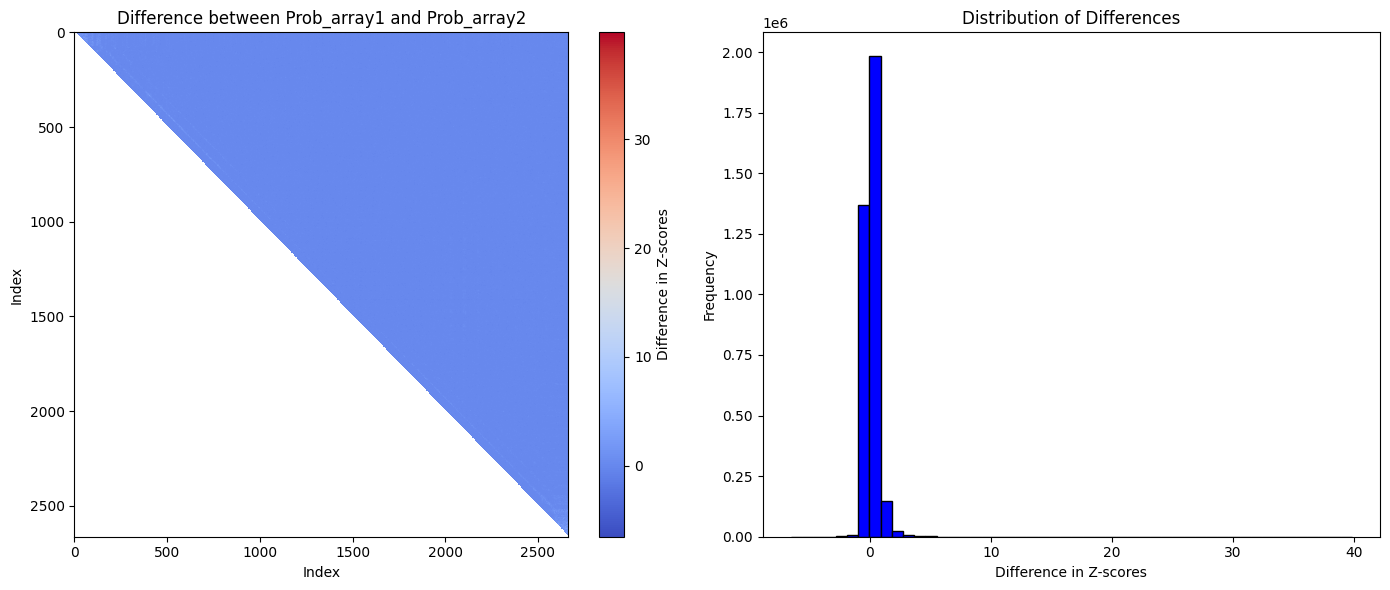

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Carica le matrici
prob_array1 = np.load("X:/zscore t2m_2022_2100_highemission/zscores_npy_year2022.npy")
prob_array2 = np.load("X:/Zscores IAAFT CMIP6 high emission/zscores_npy_year2022.npy")

# Calcola la differenza tra le due matrici
difference = prob_array1 - prob_array2

# Visualizza la differenza come una heatmap
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(difference, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Difference in Z-scores')
plt.title('Difference between Prob_array1 and Prob_array2')
plt.xlabel('Index')
plt.ylabel('Index')

# Visualizza la distribuzione delle differenze
plt.subplot(1, 2, 2)
plt.hist(difference.flatten(), bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Differences')
plt.xlabel('Difference in Z-scores')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
